### Feature engineering:
  \+ [Extracting date/time features](#Extracting-date/time-features) &nbsp; [to create detailed periods](#Engineer-Features-for-train-data)  <br/>
  \+ [Common breeds as features](#Get-common-breeds)  <br/>
  \+ [Partition SexuponOutcome column](#Get-common-colors)  <br/>
  \+ [Transforming names into name_present column](#Engineer-Features-for-train-data)  <br/>
  \+ [Hot encoding categorical data](#Engineer-Features-for-train-data)  <br/>
  \+ [AgeuponOutcome column into days](#Engineer-Features-for-train-data)  <br/>
  \+ [Polynomial of best feature](#Engineer-Features-for-train-data)  <br/>
  \- [Common colors as features](#Get-common-colors)  <br/>
  \- [Log of best feature](#Engineer-Features-for-train-data)  <br/>
  
    

### Algorithms:
  \+\+ [Single GB_Classifier](#Single-XGBClassifier-without-utilizing-OutcomeSubtype)  <br/>
  \- [2-level GB_Classifier predicting OutcomeSubtype and label](#Predicting-OutcomeSubtype-first-in-order-to-use-it-to-predict-label)  <br/>
  \+ [LogisticRegression](#Try-out-common-algorithms)  <br/>
  \+ [RF_Classifier](#Try-out-common-algorithms)  <br/>
  \- [SVC](#Try-out-common-algorithms)  <br/>
  \- [KNN_Classifier](#Try-out-common-algorithms)  <br/>
  \- [GaussianNB](#Try-out-common-algorithms)  <br/>



In [152]:
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, mode
from datetime import datetime
from calendar import month_name, day_name
from functools import partial as pt
%matplotlib inline

In [153]:
import re
from collections import Counter

## Useful functions

In [154]:
def trans_feat(data, func, old_col, new_col, drop_old=False):
    data.loc[:, new_col] = data.loc[:, old_col].apply(func)
    if drop_old:
        data = data.drop([old_col], axis=1)
    return data

def str_in_str(val_1, val_2):
    return int(str(val_1) in str(val_2))

def getWords(text):
    return re.compile('\w+').findall(text) + [text]

def max_hot_features(data, old_col):
    return set(reduce(lambda lst, val: lst + getWords(str(val)), data[old_col].unique(), []))

def hot_encode(data, old_col, features, drop_old=False, old_col_naming=True): 
    for feature in features:
        name = feature
        if old_col_naming:
            name = old_col + '_' + feature
        data = trans_feat(data, pt(str_in_str, feature), old_col, name)
    if drop_old:
        data = data.drop([old_col], axis=1)
    return data

def parse_id(id):
    return int(id[1:])

def as_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

def get_date(date_time_str):
    return date_time_str.split()[0]

def get_time(date_time_str):
    return int(date_time_str.split()[1].split(':')[0])

def get_day(date_str):
    return as_date(date_str).day

def get_month(date_str):
    return as_date(date_str).month

def get_year(date_str):
    return as_date(date_str).year

def get_ordinal(date_str):
    return as_date(date_str).toordinal()
    
def get_weekday(date_str):
    return as_date(date_str).isoweekday()

def is_period(period, unit): 
    # e.g. monday in weekend -> 1 in [6,7] 
    return int(unit in period) 

def isNaN(val):
    return val != val

def name_present(name):
    return int(isNaN(name))

def is_dog(animal):
    return int(animal == 'Dog')

def days_in(period):
    if isNaN(period): return period
    nr = int(period.split()[0])
    if 'day' in period: return nr
    elif 'week' in period: return nr*7
    elif 'month' in period: return int(np.round(nr*30.4375))
    elif 'year' in period: return int(np.round(nr*365.24))
    print 'Error! Unexpected period.'
    
def na_to_mean(data, feat):
    nums = filter(lambda val: not isNaN(val), data.loc[:, feat])
    data = data.fillna(int(np.round(np.mean(nums))))
    return data

def tbl_print(dictionary, sort_col, asc=True):
    return pd.DataFrame(dictionary).sort_values(sort_col, ascending=asc)

def try_algorithms(algos): # {algo_name: {param_name: param}}
    for name, lst in algos.iteritems():
        algo_fn, params = lst[0], lst[1]
        algo = algo_fn(**params)
        algo.fit(x_train, y_train)
        y_pred = algo.predict_proba(x_test)
        print name + ':', log_loss(list(y_test), y_pred)

In [155]:
label = 'OutcomeType'

In [156]:
raw_dataset = pd.read_csv("train.csv") 
dataset = raw_dataset.copy()

In [157]:
test_dataset_raw = pd.read_csv("test.csv") 

## Column info

In [158]:
col_notes = {
    'AnimalID': 'delete',
    'Name': 'delete?',
    'DateTime': 'fewer samples in 2013 & 2016',
    'OutcomeType': 'label',
    'OutcomeSubtype': '???',
    'SexuponOutcome': 'cols: neutering/sex',
    'AgeuponOutcome': 'cat to num',
    'Breed': 'multitude of categories possible',
    'Color': 'multitude of categories possible'
}

d = {'NAME': [], 
     'EX_1': [], 
     'EX_2': [], 
     'NULLS': [], 
     'UNIQUE': [],
     'NOTES': []}

dataset_len = len(dataset)

for col in list(dataset):    
    unique_val_1 = np.array(pd.Series(dataset[col].unique()).dropna())[0]
    unique_val_2 = np.array(pd.Series(dataset[col].unique()).dropna())[1]
  
    nulls = dataset[col].isnull().sum() / dataset_len
    nulls = str(nulls*100)[:4] + '%'
    note = col_notes[col] if col in col_notes else '---'
    
    d['NAME']      = d['NAME']      + [col]
    d['EX_1']      = d['EX_1']      + [unique_val_1]
    d['EX_2']      = d['EX_2']      + [unique_val_2]
    d['NULLS']     = d['NULLS']     + [nulls]
    d['UNIQUE']    = d['UNIQUE']    + [len(dataset[col].unique())]
    d['NOTES']     = d['NOTES']     + [note]

with pd.option_context('display.max_rows', len(d['NAME']), 'expand_frame_repr', False):
    print pd.DataFrame(d)[['NAME', 'EX_1', 'EX_2', 'UNIQUE', 'NULLS', 'NOTES']]

             NAME                   EX_1                    EX_2  UNIQUE  NULLS                             NOTES
0        AnimalID                A671945                 A656520   26729   0.0%                            delete
1            Name                Hambone                   Emily    6375  28.7%                           delete?
2        DateTime    2014-02-12 18:22:00     2013-10-13 12:44:00   22918   0.0%      fewer samples in 2013 & 2016
3     OutcomeType        Return_to_owner              Euthanasia       5   0.0%                             label
4  OutcomeSubtype              Suffering                  Foster      17  50.9%                               ???
5      AnimalType                    Dog                     Cat       2   0.0%                               ---
6  SexuponOutcome          Neutered Male           Spayed Female       6  0.00%               cols: neutering/sex
7  AgeuponOutcome                 1 year                 2 years      45  0.06%         

In [159]:
from sklearn.model_selection import train_test_split

x = dataset.drop([label], axis=1)
y = dataset.loc[:, label]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=12)

In [160]:
x_test

,AnimalID,Name,DateTime,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
22083,A686749,NaN,2014-08-26 14:02:00,Partner,Cat,Intact Male,2 weeks,Domestic Shorthair Mix,Black Smoke
12118,A694496,Leo,2015-01-06 14:25:00,Partner,Dog,Neutered Male,2 years,Labrador Retriever Mix,Black
17599,A706911,Hildee,2015-07-18 17:43:00,NaN,Cat,Spayed Female,2 months,Domestic Shorthair Mix,Tortie
2249,A689616,Vincent,2014-10-11 18:33:00,NaN,Cat,Neutered Male,2 years,Domestic Longhair Mix,Black Smoke
17394,A699338,Wilbur,2015-08-10 11:09:00,Partner,Dog,Neutered Male,1 year,Labrador Retriever Mix,Buff
17776,A689828,Barbie,2014-10-20 18:51:00,NaN,Dog,Spayed Female,2 years,American Staffordshire Terrier Mix,Blue/White
25052,A693635,Sallie,2014-12-20 11:06:00,NaN,Dog,Spayed Female,3 years,German Shepherd Mix,Black/Brown
12899,A661131,Robbin,2013-10-13 14:22:00,NaN,Cat,Spayed Female,4 months,Domestic Shorthair Mix,Cream Tabby
17988,A674206,Tiger,2014-03-22 12:25:00,NaN,Cat,Spayed Female,5 years,Domestic Longhair Mix,Torbie/White
22552,A714360,NaN,2015-10-29 11:58:00,Partner,Cat,Neutered Male,2 years,Domestic Medium Hair Mix,Blue Tabby


In [161]:
y_train_sub = x_train.loc[:, 'OutcomeSubtype'].fillna('NAN')
y_test_sub  = x_test.loc[:, 'OutcomeSubtype'].fillna('NAN')

x_train = x_train.drop(['OutcomeSubtype'], axis=1)
x_test  = x_test.drop(['OutcomeSubtype'], axis=1)

## Extracting date/time features

In [162]:
def extract_date_time(data):
    data = trans_feat(data, get_date, 'DateTime', 'Date')
    data = trans_feat(data, get_time, 'DateTime', 'Time', drop_old=True)
    data = trans_feat(data, get_year, 'Date', 'Year')
    data = trans_feat(data, get_month, 'Date', 'Month')
    data = trans_feat(data, get_day, 'Date', 'Day')
    data = trans_feat(data, get_weekday, 'Date', 'Weekday')
    data = trans_feat(data, get_ordinal, 'Date', 'Ordinal')
    return data

In [163]:
x_train = extract_date_time(x_train)

In [164]:
x_train[:2]

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Date,Time,Year,Month,Day,Weekday,Ordinal
3530,A691273,Sky,Dog,Spayed Female,4 months,Plott Hound Mix,Brown Brindle/White,2014-11-07,13,2014,11,7,5,735544
19211,A672021,Fritz,Dog,Neutered Male,2 years,Yorkshire Terrier Mix,Blue/Tan,2014-03-16,15,2014,3,16,7,735308


## Visualizations

In [165]:
x_y_train = x_train.copy()
x_y_train.loc[:, label] = y_train

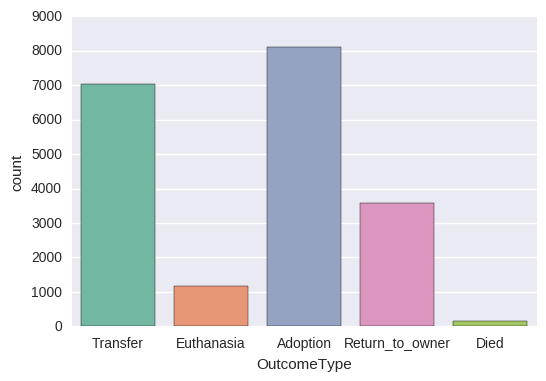

In [166]:
fig, ax = plt.subplots()
sns.countplot(x=label, data=x_y_train, palette='Set2')
plt.show()

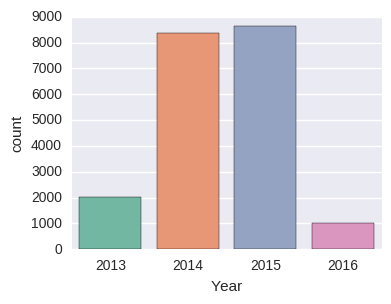

In [167]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x='Year', data=x_y_train, palette='Set2')
plt.show()

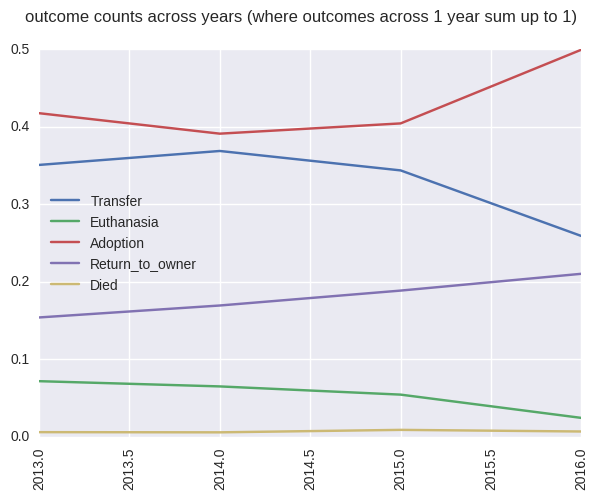

                2013 & 2016 highly influenced by months


In [168]:
outcome_year = x_y_train.groupby([label, 'Year'])['Year'].count()
mean_years = [outcome_year[:, year].sum() for year in [2013, 2014, 2015, 2016]]

plt.figure(figsize=(7,5)).suptitle('outcome counts across years (where outcomes across 1 year sum up to 1)', fontsize=12)


for outcome in x_y_train[label].unique():
    normalized_means = np.array(outcome_year[outcome].values) / np.array(mean_years)
    plt.plot(outcome_year[outcome].index, normalized_means)
    
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.xticks(rotation='vertical')
plt.legend(x_y_train[label].unique(), loc=6)
plt.show()

print '                2013 & 2016 highly influenced by months' 

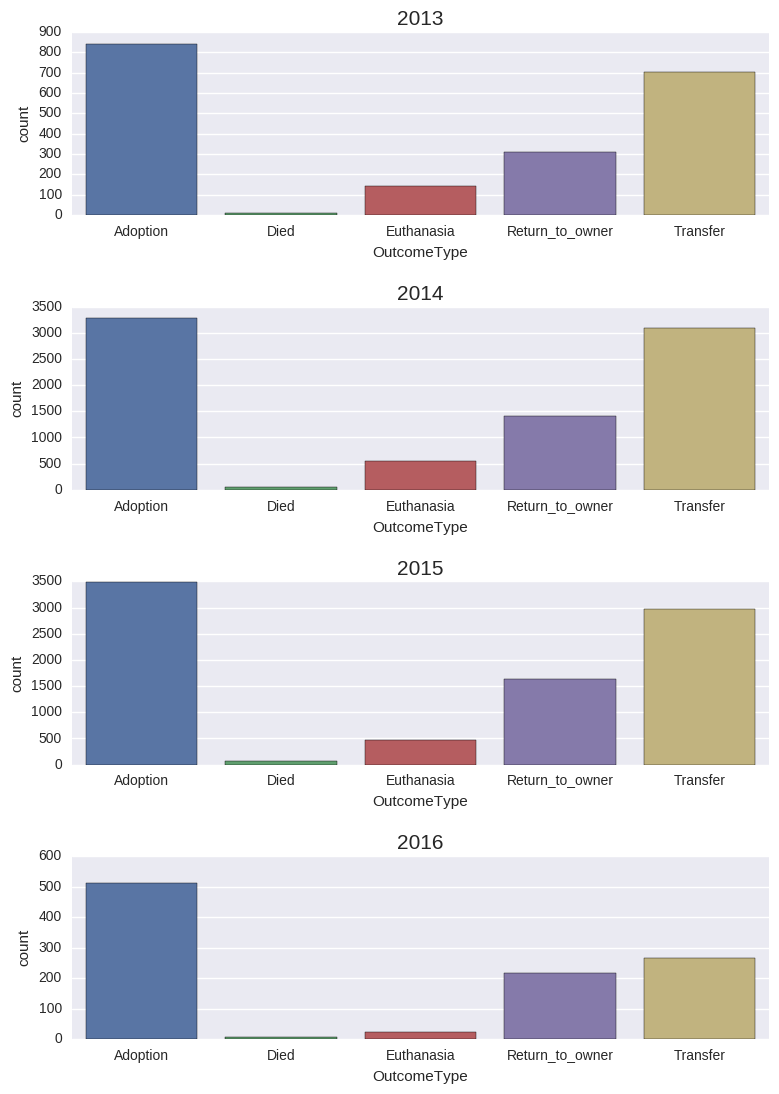

In [169]:
fig, axs = plt.subplots(ncols=1, nrows=len(set(x_y_train['Year'])), figsize=(9,13)) # , ylim=(0,3500)
plt.subplots_adjust(hspace=0.5)
sorted_labels = sorted(set(list(x_y_train[label])))

for i, d in enumerate(x_y_train.groupby(['Year'])):
    sns.countplot(x=label, data=d[1], ax=axs[i], order=sorted_labels).axes.set_title(str(d[0]), fontsize=15)

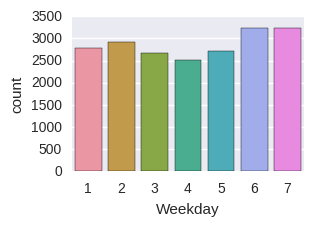

In [170]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.countplot(x='Weekday', data=x_y_train)
plt.show()

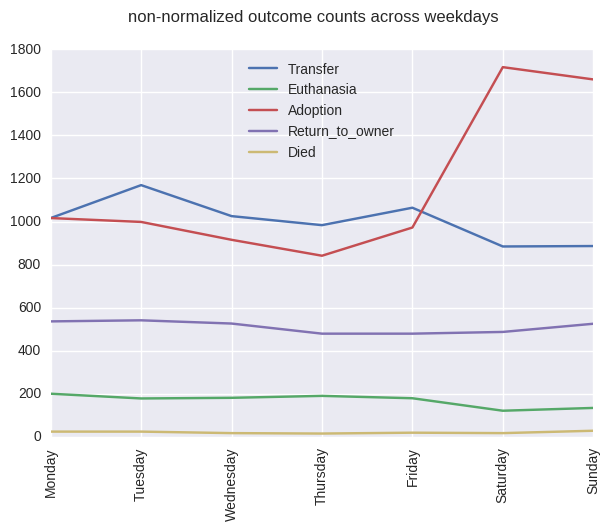

In [171]:
outcome_weekday = x_y_train.groupby([label, 'Weekday'])['Weekday'].count()

plt.figure(figsize=(7,5)).suptitle('non-normalized outcome counts across weekdays', fontsize=12)

for outcome in x_y_train[label].unique():
    plt.plot(outcome_weekday[outcome])
  
plt.xticks(range(1,8), [day_name[n] for n in range(7)], rotation='vertical')
plt.legend(x_y_train[label].unique(), loc=9)
plt.show()

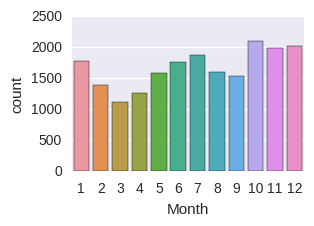

In [172]:
fig, ax = plt.subplots(figsize=(3, 2))
sns.countplot(x='Month', data=x_y_train)
plt.show()

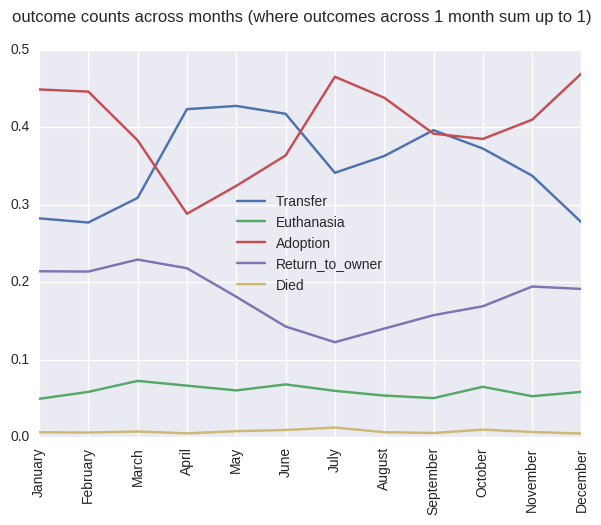

In [173]:
outcome_month = x_y_train.groupby([label, 'Month'])['Month'].count()
mean_months = [outcome_month[:, mon].sum() for mon in range(1,13)]

plt.figure(figsize=(7,5)).suptitle('outcome counts across months (where outcomes across 1 month sum up to 1)', fontsize=12)

for outcome in x_y_train[label].unique():
    months_normalized = np.array(outcome_month[outcome].values) / np.array(mean_months)
    plt.plot(outcome_month[outcome].index, months_normalized)

axes = plt.gca()
axes.set_xlim([1, 12])

plt.xticks(range(1, 13), [month_name[n] for n in range(1,13)], rotation='vertical')
plt.legend(x_y_train[label].unique(), loc='best')
plt.show()

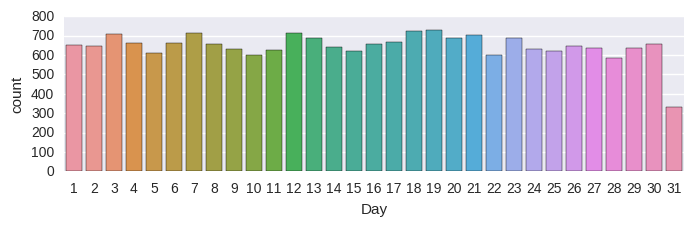

In [174]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(x='Day', data=x_y_train)
plt.show()

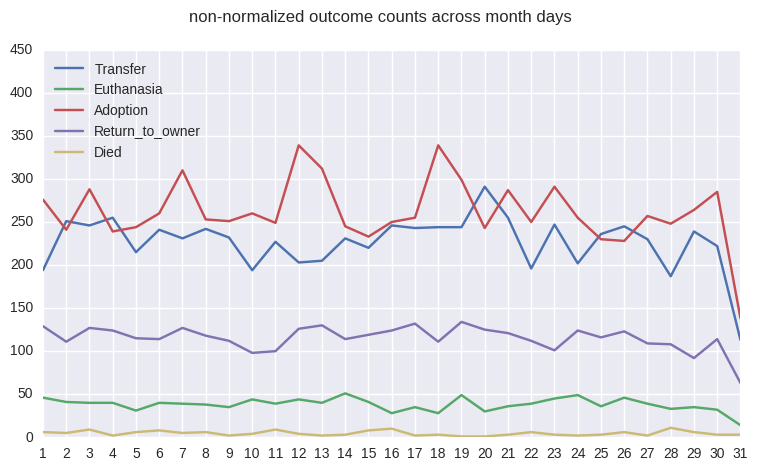

In [175]:
outcome_monthday = x_y_train.groupby([label, 'Day'])['Day'].count()

plt.figure(figsize=(9,5)).suptitle('non-normalized outcome counts across month days', fontsize=12)

for outcome in x_y_train[label].unique():
    plt.plot(outcome_monthday[outcome])

plt.xticks(range(0,32))
plt.yticks(range(0,451, 50))
axes = plt.gca()
axes.set_xlim([1, 31])
plt.legend(x_y_train[label].unique(), loc=2)
plt.show()

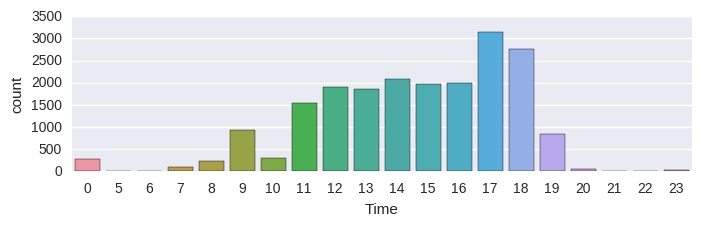

In [176]:
fig, ax = plt.subplots(figsize=(8, 2))
sns.countplot(x='Time', data=x_y_train)
plt.show()

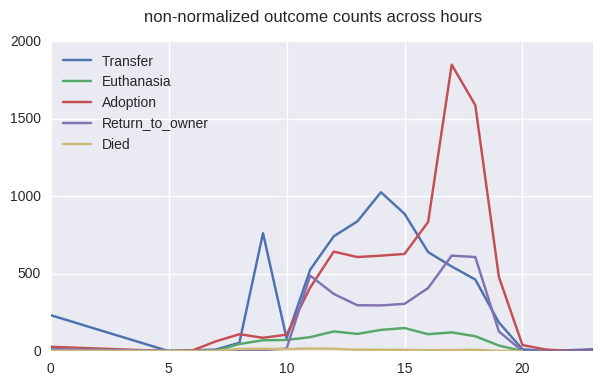

In [177]:
outcome_times = x_y_train.groupby([label, 'Time'])['Time'].count()

plt.figure(figsize=(7,4)).suptitle('non-normalized outcome counts across hours', fontsize=12)

for outcome in x_y_train[label].unique():
    plt.plot(outcome_times[outcome])

axes = plt.gca()
axes.set_xlim([min(x_y_train['Time']), max(x_y_train['Time'])])
    
plt.legend(x_y_train[label].unique(), loc=2)
plt.show()

## Get common breeds

In [178]:
dog_breeds = ['Labrador Retriever', 'Yorkshire Terrier', 'German Shepherd', 'Golden Retriever', 'Beagle', 'Dachshund', 'Boxer', 'Poodle', 'Chihuahua', 'Shih Tzu', 'Miniature Schnauzer', 'Bulldog', 'German Spitz', 'Spaniel', 'Pug', 'Rottweiler', 'Pit Bull']
cat_breeds = ['Domestic Shorthair', 'American Shorthair', 'Tabby', 'Calico', 'Maine Coon', 'Siamese', 'Mixed', 'Domestic Mediumhair', 'Tuxedo', 'Tortoiseshell']
other_breeds = ['Mix', 'Domestic', 'Australian', 'American']

breed_string = ' '.join(list(x_train['Breed']))

d_breeds = filter(lambda breed: breed in breed_string, dog_breeds)
c_breeds = filter(lambda breed: breed in breed_string, cat_breeds)

## Get common colors

In [179]:
common_colors = map(lambda x: x[0], Counter(getWords(' '.join(x_train['Color']))).most_common(10))

## Get sex features 

In [180]:
sex_features = max_hot_features(x_train, 'SexuponOutcome')

## Engineer Features for train data

In [181]:
def engineer_features(data):

    if 'AnimalID' in list(data): # not present in test_dataset
        data = data.drop('AnimalID', axis=1)

    for year in range(2013, 2017):
        data = trans_feat(data, pt(is_period, [year]), 'Year', 'is_' + str(year))

    data = trans_feat(data, pt(is_period, [6,7]), 'Weekday', 'is_weekend')

    for weekday_idx in range(1, 8):
        data = trans_feat(data, pt(is_period, [weekday_idx]), 'Weekday', 'is_' + day_name[weekday_idx - 1])

    data = trans_feat(data, pt(is_period, [11,12,1,2,3]), 'Month', 'is_nov_to_mar')
    data = trans_feat(data, pt(is_period, [4,5,6]),       'Month', 'is_apr_to_jun')
    data = trans_feat(data, pt(is_period, [7,8]),         'Month', 'is_jul_to_aug')
    data = trans_feat(data, pt(is_period, [9,10]),        'Month', 'is_sept_to_oct')

    for month_idx in range(1, 13):
        data = trans_feat(data, pt(is_period, [month_idx]), 'Month', 'is_' + month_name[month_idx])

    data = trans_feat(data, pt(is_period, [9]),          'Time', 'is_nine_oclock')
    data = trans_feat(data, pt(is_period, range(10,17)), 'Time', 'is_noon')
    data = trans_feat(data, pt(is_period, range(16,21)), 'Time', 'is_evening')

    for hour in range(0, 24):
        data = trans_feat(data, pt(is_period, [hour]), 'Day', 'is_' + str(hour))

    data = trans_feat(data, name_present, 'Name', 'name_present', drop_old=True)
    data = trans_feat(data, is_dog, 'AnimalType', 'is_dog', drop_old=True)

    data = hot_encode(data, 'SexuponOutcome', sex_features, drop_old=True)

    data = trans_feat(data, days_in, 'AgeuponOutcome', 'days_upon_outcome', drop_old=True)
    data = na_to_mean(data, 'days_upon_outcome')

    data = hot_encode(data, 'Breed', d_breeds + c_breeds + other_breeds, drop_old=True)

    #data = hot_encode(data, 'Color', common_colors, drop_old=True)

    data = trans_feat(data, lambda x: x**2, 'days_upon_outcome', 'days_upon_outcome_sq', drop_old=False)
    #data = trans_feat(data, lambda x: np.log(x), 'days_upon_outcome', 'days_upon_outcome_log', drop_old=True)
    
    data = data.drop(['Ordinal', 'Date', 'Year', 'Day', 'Time', 'Month', 'Weekday', 'Color'], axis=1)
    
    return data

In [182]:
x_train = engineer_features(x_train)

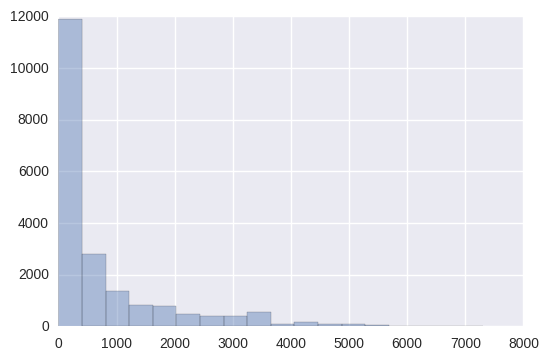

In [183]:
sns.distplot(list(x_train['days_upon_outcome']), bins = 18, kde=False)

## Extract date/time & engineer features for test data

In [184]:
x_test = extract_date_time(x_test)
x_test = engineer_features(x_test)

## Try out common algorithms

In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

try_algorithms({
     #'RidgeLogReg':    [LogisticRegression, {'penalty': 'l2'}],
     'LassoLogReg':    [LogisticRegression, {'penalty': 'l1'}], 
     'SVC':            [SVC, {'probability': True}],
     'KNN_Classifier': [KNeighborsClassifier, {}],
     'GaussianNB':     [GaussianNB, {}], 
     'GB_Classifier':  [GradientBoostingClassifier, {}],
     'RF_Classifier':  [RandomForestClassifier, {'n_estimators': 500}]
})

LassoLogReg: 0.862599009233
GaussianNB: 1.59215993769
SVC: 0.910861320278
KNN_Classifier: 4.52414315886
GB_Classifier: 0.793640823841
RF_Classifier: 0.87567859131


In [186]:
from sklearn.model_selection import GridSearchCV

param_grid = { # after trying diff params
    'max_features': ['sqrt'],
    'min_samples_split': [4],
    'min_samples_leaf': [1],
    'warm_start': [False]
}

random_forest = GridSearchCV(estimator=RandomForestClassifier(n_estimators=500), param_grid=param_grid, cv=5)

random_forest.fit(x_train, y_train)
preds_train = random_forest.predict_proba(x_train)
preds_test = random_forest.predict_proba(x_test)

print 'train:', log_loss(list(y_train), preds_train)
print 'test:', log_loss(list(y_test), preds_test)

train: 0.318831603676
test: 0.813524117846


In [187]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#------- XGBRegressor ----------#

XGBC_sub_params = {
    'learning_rate': 0.1,
    'min_child_weight': 0.1, # 1 [0.1, 0.08, 0.12]
    'max_depth': 7,          # 2 [5,6,7]
    'gamma': 0.1,            # 3 [0.1, 0.08, 0.12]
    'subsample': 0.7,        # 4 [0.7, 0.8, 0.9]
    'colsample_bytree': 0.6, # 5 [0.6, 0.7, 0.8]
    'reg_alpha': 0.1,        # 6 [0,1,0.1,0.9]
    'reg_lambda': 0,         # 7 [0,1,0.1,0.9]
    'n_estimators': 100,
    'objective': 'mlogloss',
}
XGBC_sub_grid_dict = {
     #'learning_rate': [0.001, 0.005, 0.01],
}

XGBC_params = {
    'learning_rate': 0.1,
    'min_child_weight': 0.1, # 1 [0.1, 0.08, 0.12]
    'max_depth': 8,          # 2 [6,7,8]  
    'gamma': 0,              # 3 [0, 0.1, 0.12]
    'subsample': 0.9,        # 4 [0.7, 0.8, 0.9]
    'colsample_bytree': 0.8, # 5 [0.6, 0.7, 0.8]
    'reg_alpha': 0,          # 6 [0,0.1,0.9,1]
    'reg_lambda': 1,         # 7 [0,0.1,0.9,1]
    'n_estimators': 100,
    'objective': 'mlogloss',
}
XGBC_grid_dict = {
    #'reg_lambda': [0,0.1,0.9,1],
}

## Predicting OutcomeSubtype first in order to use it to predict label

In [188]:
# x_train_sub = x_train[18000:]
# y_train_sub = y_train_sub[18000:]

# x_train = x_train[:18000]
# y_train = y_train[:18000]

# cv_xgb_sub = StratifiedKFold(y_train_sub.values, n_splits=5, shuffle=True)

# best_xgb_sub = GridSearchCV(estimator=XGBClassifier(**XGBC_sub_params), param_grid=XGBC_sub_grid_dict, cv=cv_xgb_sub)
# best_xgb_sub.fit(x_train_sub, y_train_sub) # predicting OutcomeSubtype

# x_train['sub_class'] = best_xgb_sub.predict(x_train)
# x_test['sub_class']  = best_xgb_sub.predict(x_test)

# sub_class_hot_features = set(x_train['sub_class'])

# x_train = hot_encode(x_train, 'sub_class', sub_class_hot_features, drop_old=True)
# x_test  = hot_encode(x_test,  'sub_class', sub_class_hot_features, drop_old=True)

## Single XGBClassifier without utilizing OutcomeSubtype

In [189]:
from sklearn.model_selection import StratifiedKFold
from xgboost.sklearn import XGBClassifier

# unbalanced labels
cv_best_xgb = StratifiedKFold(5)

best_xgb = GridSearchCV(estimator=XGBClassifier(**XGBC_params), param_grid=XGBC_grid_dict, cv=cv_best_xgb)

best_xgb.fit(x_train, y_train)
preds_train = best_xgb.predict_proba(x_train)
preds_test = best_xgb.predict_proba(x_test)

In [190]:
# log on the error provides extreme punishments for being both confident and wrong

print 'train:', log_loss(list(y_train), preds_train)
print 'test:', log_loss(list(y_test), preds_test)

train: 0.530688391094
test: 0.761755975352


## Feature importances

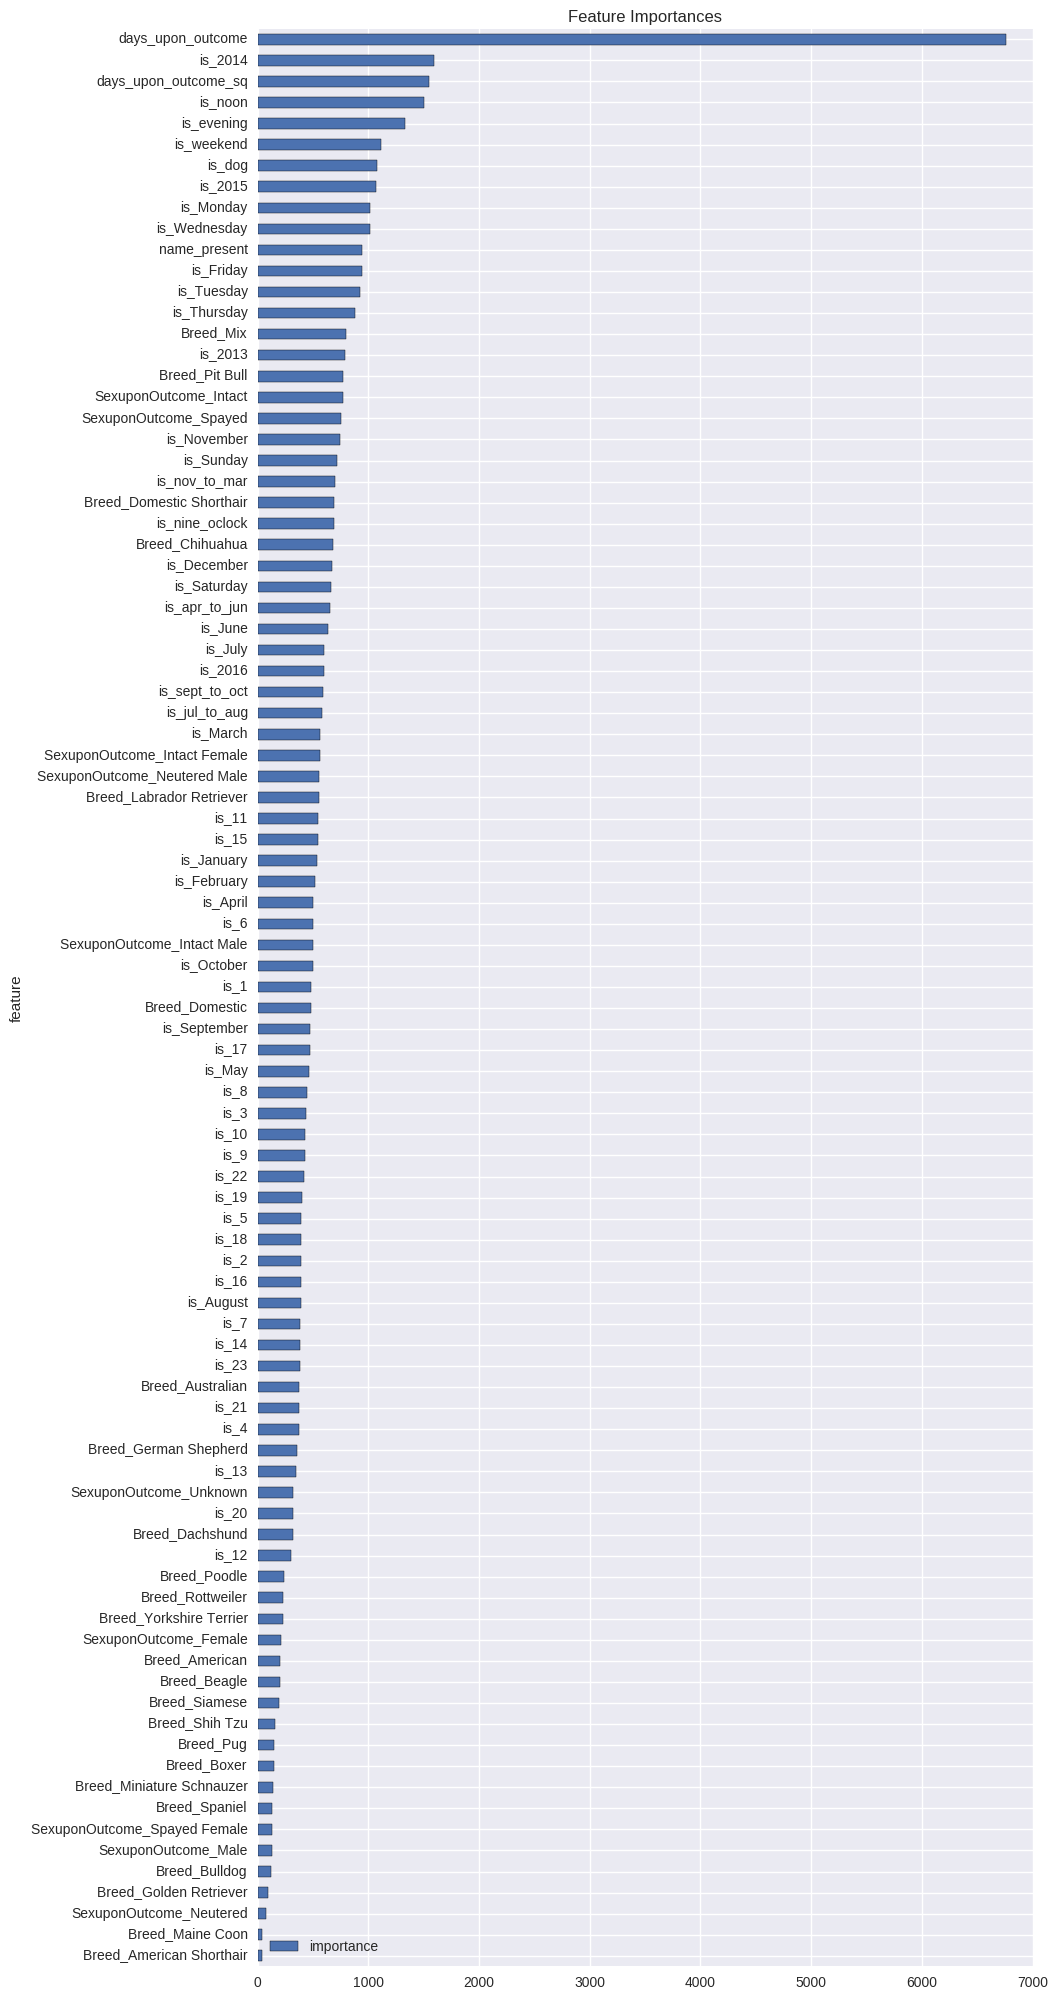

In [192]:
feature_importances = best_xgb.best_estimator_.booster().get_score()
feature_imps_df = pd.DataFrame({'feature': feature_importances.keys(), 'importance': feature_importances.values()})
feature_imps_df = feature_imps_df.sort_values('importance').set_index('feature')
feature_imps_df.plot.barh(figsize=(10,25)).set_title('Feature Importances')
plt.show()

## Submission

In [193]:
test_dataset = test_dataset_raw.drop('ID', axis=1)

In [194]:
test_dataset = extract_date_time(test_dataset)
test_dataset = engineer_features(test_dataset)

test_preds = best_xgb.predict_proba(test_dataset)

In [195]:
test_preds_df = pd.DataFrame(test_preds, columns=best_xgb.best_estimator_.classes_)
test_preds_df['ID'] = test_dataset_raw['ID']

# test_preds_df.to_csv("animals_05.csv", index=False)

In [ ]:
# submission 1 - 11.17626
# submission 2 - 0.92409
# submission 3 - 0.80804
# submission 4 - 0.75958
# submission 5 - 0.75166